In [0]:
from PIL import Image
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import torchvision
from torchvision import transforms
from torchvision import models
from collections import Counter
from pathlib import Path
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sn
# !pip install torchsummary 
# import torchsummary

In [2]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.20.5 (Git Hash 0125f28c61c1f822fd48570b4c1066f96fcb9b2e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_37,code=compute_37
  - CuDNN 7.6.3
  - Magma 2.5.1
  - Build settings: BLAS=MKL, BUILD_NAMEDTENSOR=OFF, BUILD_TYPE=Release, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -fopenmp -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -O2 -fPIC -Wno-narrowing -Wall -Wextra -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-sign-compare -Wno-unused-parameter -Wno-unused-variabl

In [3]:
torch.get_num_threads()

2

In [0]:
torch.set_num_threads(4)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df_train = pd.read_csv('/content/gdrive/My Drive/kaggle/train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/kaggle/test.csv')
df_class = pd.read_csv('/content/gdrive/My Drive/kaggle/class_map.csv')
df_submission = pd.read_csv('/content/gdrive/My Drive/kaggle/sample_submission.csv')

In [0]:
def make_tensordataset_from_dfs(parquet_locs, label_loc=None):
    ids = []
    X = []
#     parquet_locs = notebook.tqdm(parquet_locs)
    for parquet_loc in parquet_locs:
        df = pd.read_parquet(parquet_loc)
        ids.extend(df.image_id.tolist())
        x = df.iloc[:, 1:].to_numpy(dtype=np.uint8)
        del df
        X.append(x)
    X = np.vstack(X)
    X = X.reshape(-1, 1, 137, 236)
    X = torch.from_numpy(X)
    ids = dict((s,i) for (i,s) in enumerate(ids))
    if label_loc is None:
        return TensorDataset(X)
    else:
        graphemes = torch.zeros(X.shape[0], dtype=torch.long)
        vowel_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        consonant_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        lbl_df = pd.read_csv(label_loc)
        for row in lbl_df.itertuples():
            if row.image_id not in ids:
                continue
            idx = ids[row.image_id]
            graphemes[idx] = row.grapheme_root
            vowel_diacs[idx] = row.vowel_diacritic
            consonant_diacs[idx] = row.consonant_diacritic
        return TensorDataset(X, graphemes, vowel_diacs, consonant_diacs)

In [0]:
ds = make_tensordataset_from_dfs(['/content/gdrive/My Drive/kaggle/train_image_data_{}.parquet'.format(i) for i in range(4)], '/content/gdrive/My Drive/kaggle/train.csv')

(tensor(72),
 tensor(4),
 tensor(0),
 tensor(255, dtype=torch.uint8),
 tensor(34, dtype=torch.uint8))

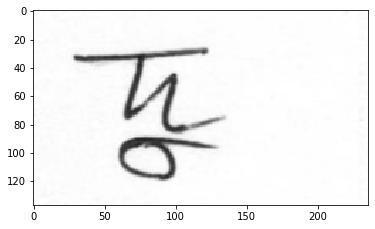

In [10]:
plt.imshow(ds[100000][0].permute(1, 2, 0).reshape(137, 236), cmap='gray', vmin=0, vmax=255)
ds[100000][1], ds[100000][2], ds[100000][3], ds[100000][0].max(), ds[100000][0].min()

In [0]:
tr_indices, va_indices = train_test_split(list(range(len(ds))), test_size=.1, train_size=.9, random_state=42)#, stratify=ds.tensors[1])

In [0]:
tr_ds = Subset(ds, tr_indices)
va_ds = Subset(ds, va_indices)

In [13]:
len(ds), len(tr_ds), len(va_ds)

(200840, 180756, 20084)

In [0]:
n_graphemes, n_vowel_diacs, n_consonant_diacs = len(set(df_train['grapheme_root'])), len(set(df_train['vowel_diacritic'])), len(set(df_train['consonant_diacritic']))

In [0]:
def make_linear_block(in_size, out_size):
    block = nn.Sequential(
        nn.Linear(in_size, out_size),
        nn.ReLU(), 
        nn.BatchNorm1d(num_features=out_size),
        nn.Dropout(0.1)
    )
    nn.init.xavier_normal_(block[0].weight.data)
    nn.init.zeros_(block[0].bias.data)
    return block

def make_ff_predictor(in_size, intermediate_size, out_size, layer_count):
    layers = [make_linear_block(in_size, intermediate_size)]
    for i in range(layer_count):
        layers.append(make_linear_block(intermediate_size, intermediate_size))
    layers.append(make_linear_block(intermediate_size, out_size))
    layers = nn.Sequential(*layers)
    return layers

class BanglaHandwrittenGraphemeNN(nn.Module):
    def __init__(self):
        super(BanglaHandwrittenGraphemeNN, self).__init__()
        base = models.resnet50(pretrained=False)
        base.fc = nn.Identity()
        self.base = base
        feature_size = 2048
        self.grapheme_predictor = make_ff_predictor(feature_size, 1024, n_graphemes, 5)
        self.vowel_diac_predictor = make_ff_predictor(feature_size, 512, n_vowel_diacs, 3)
        self.consonant_diacs = make_ff_predictor(feature_size, 512, n_consonant_diacs, 3)

    def convert_to_grayscale(self):
        with torch.no_grad():
            conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            conv1.weight.data = torch.sum(model.base.conv1.weight.data, dim=1, keepdim=True)
            self.base.conv1 = conv1
            
    def freeze(self):
        for p in self.base.parameters():
            p.requires_grad = False
        
    def unfreeze(self):
        for p in self.base.parameters():
            p.requires_grad = True
        
    def forward(self, x):
        features = self.base(x)
        g_pred = self.grapheme_predictor(features)
        v_pred = self.vowel_diac_predictor(features)
        c_pred = self.consonant_diacs(features)
        return g_pred, v_pred, c_pred

In [0]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [0]:
model = BanglaHandwrittenGraphemeNN().to(device)

In [0]:
model.convert_to_grayscale()

In [0]:
model.unfreeze()

In [0]:
tr_dl = DataLoader(tr_ds, batch_size=64, num_workers=0, pin_memory=True, shuffle=True)
va_dl = DataLoader(va_ds, batch_size=64, num_workers=0, pin_memory=True)

In [0]:
gloss = LabelSmoothingLoss(168, smoothing=0.05)
vloss = LabelSmoothingLoss(11, smoothing= 0.1)
closs = LabelSmoothingLoss(7, smoothing= 0.1)

In [0]:
criterion = [gloss,vloss,closs]

In [0]:
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [0]:
tr_losses = []
va_losses = []

In [0]:
mean = lambda l: sum(l) / len(l)

In [0]:
def run_epochs(num_epochs):
  epochs = range(num_epochs)
  epochs = tqdm_notebook(range(num_epochs))
  for epoch in epochs:
      model.train()
      count = 0
      batches = tr_dl
      batches = tqdm_notebook(tr_dl)
      for batch in batches:
          count += 1
          optimizer.zero_grad()
          img, g, v, c = batch
          img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
          img = img / 255.0
          g_pred, v_pred, c_pred = model(img)
          g_loss = criterion[0](g_pred, g)
          v_loss = criterion[1](v_pred, v)
          c_loss = criterion[2](c_pred, c)
          loss = g_loss + v_loss + c_loss
          loss.backward()
          optimizer.step()
          tr_losses.append((g_loss.item(), v_loss.item(), c_loss.item()))
      print(mean([sum(t) for t in tr_losses]), mean([t[0] for t in tr_losses]), mean([t[1] for t in tr_losses]), mean([t[2] for t in tr_losses]))
      with torch.no_grad():
          model.eval()
          avg_g_loss = 0.0
          avg_v_loss = 0.0
          avg_c_loss = 0.0
          g_true = []
          v_true = []
          c_true = []
          g_preds = []
          v_preds = []
          c_preds = []
          count = 0
          batches = va_dl
          batches = tqdm_notebook(va_dl)
          for batch in batches:
              count += 1
              img, g, v, c = batch
              img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
              img = img / 255.0
              g_pred, v_pred, c_pred = model(img)
              g_loss = criterion[0](g_pred, g)
              v_loss = criterion[1](v_pred, v)
              c_loss = criterion[2](c_pred, c)
              avg_g_loss += g_loss.item()
              avg_v_loss += v_loss.item()
              avg_c_loss += c_loss.item()
              g_true.extend(g.tolist())
              v_true.extend(v.tolist())
              c_true.extend(c.tolist())
              g_preds.extend(g_pred.argmax(1).tolist())
              v_preds.extend(v_pred.argmax(1).tolist())
              c_preds.extend(c_pred.argmax(1).tolist())
          avg_g_loss /= count
          avg_v_loss /= count
          avg_c_loss /= count
          va_losses.append((avg_g_loss, avg_v_loss, avg_c_loss))
          print(sum(va_losses[-1]), va_losses[-1])
          print(recall_score(g_true, g_preds, average='macro'))
          print(recall_score(v_true, v_preds, average='macro'))
          print(recall_score(c_true, c_preds, average='macro'))
          print(confusion_matrix(v_true, v_preds))
          print(confusion_matrix(c_true, c_preds))
          plt.figure(figsize = (20, 20))
          sn.heatmap(np.log1p(confusion_matrix(g_true, g_preds)))
          plt.show()

8.936079585362325 5.152192708074519 1.928446155480579 1.8554407218072266


7.560291876838465 (4.652514898093643, 1.3032809940113383, 1.6044959847334843)
0.030543670495244302
0.571529258189219
0.3723334411943519
[[3241  199   14   28  332  262   25  137    5    4    1]
 [ 690 2562   14  235   39    3    0   71    7   40    1]
 [ 151    9 2106   16   15    8    0  227   37    1    7]
 [ 145  149    8 1238   14    0    0    9    3    2   11]
 [ 343   22    1    5 1136  295   46   30    3    0    0]
 [ 149   20    0    0  105  225   14    9    0    0    0]
 [  93    1    0    0  136  179   36    3    0    0    0]
 [ 232   50   27    3   40    8    1 2385   15   90    8]
 [  28   17   61    1   10    1    0  107  101    4    3]
 [  19  197    6   16    1    0    0  381   14  908   76]
 [   1   28    7   39    0    0    0   49   11   76  146]]
[[6374  181 2078   83 2658 1166   15]
 [  68   55  449    2   62   57    0]
 [ 106   44 2024    6   56   71    1]
 [   3    0   37    0   19    2    1]
 [ 249    5   57    2 1757   76    1]
 [ 673   52  254   12  503  716    

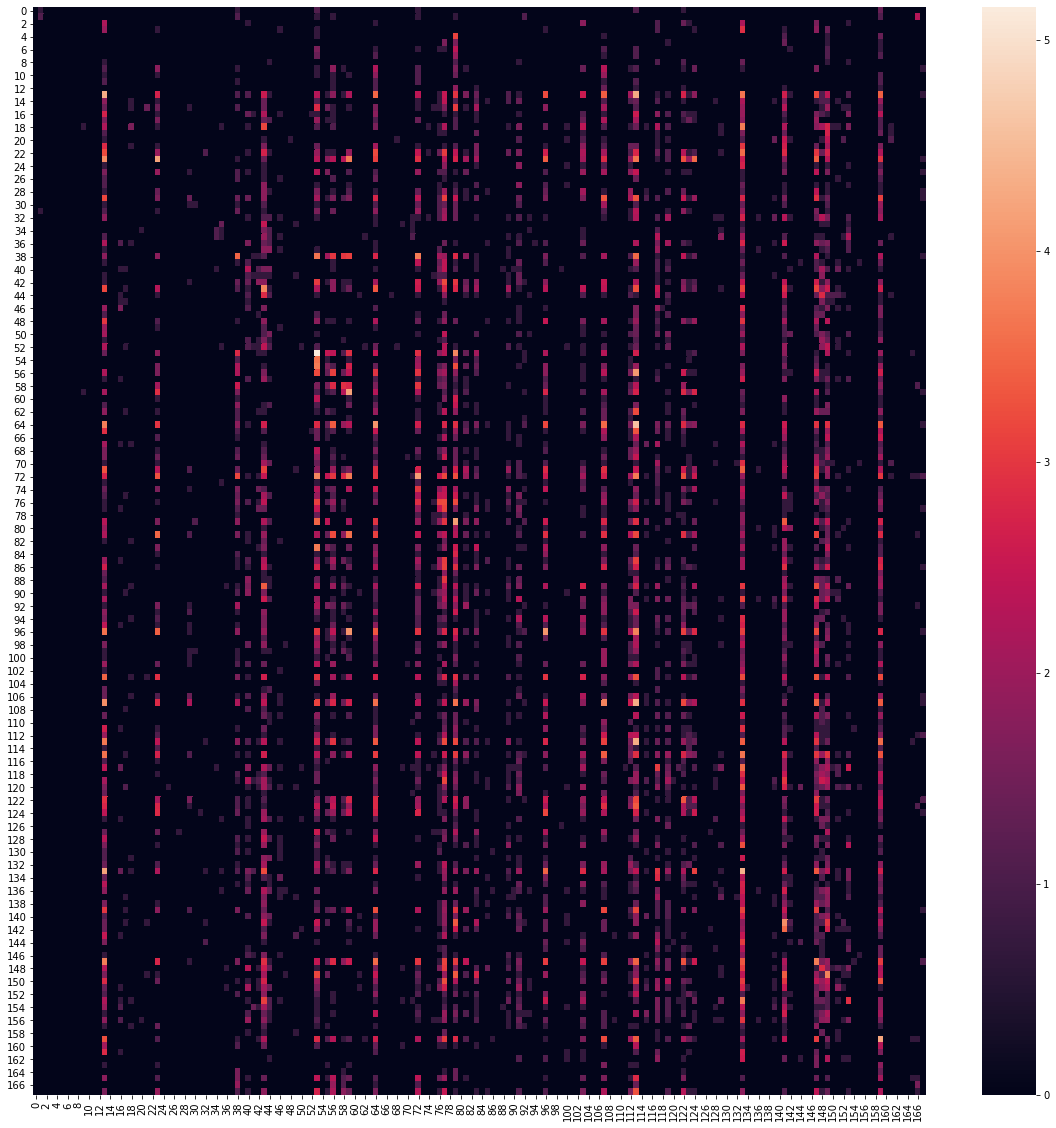

7.693625506426381 4.53784188287448 1.5744492838657007 1.5813343396861996


4.589278968656139 (2.569330423500887, 0.9539244266072656, 1.0660241185479862)
0.30562854937756584
0.8114022359496608
0.8142551059527728
[[3656   86   13    6  162  108  180   35    1    1    0]
 [ 374 3161    5   43   29    4   20   11    1   14    0]
 [  30    1 2523    1    3    1    1   16    1    0    0]
 [  64   52    5 1443    5    0    6    2    0    1    1]
 [ 175    4    2    0 1474  131   92    3    0    0    0]
 [  81    6    0    0   61  308   63    3    0    0    0]
 [  19    0    0    0   16   26  387    0    0    0    0]
 [  71    3    7    0    5    2    2 2728   11   30    0]
 [   6    6   21    0    2    1    0   58  234    2    3]
 [   0   91    1    1    1    0    0  319    2 1187   16]
 [   0    6    1    6    1    0    0   44    4   52  243]]
[[10887   326   491     0   482   362     7]
 [   36   577    74     0     2     4     0]
 [  131   110  2037     6     6    16     2]
 [    0     0     5    52     5     0     0]
 [   95     5    18    12  1996     6    15]


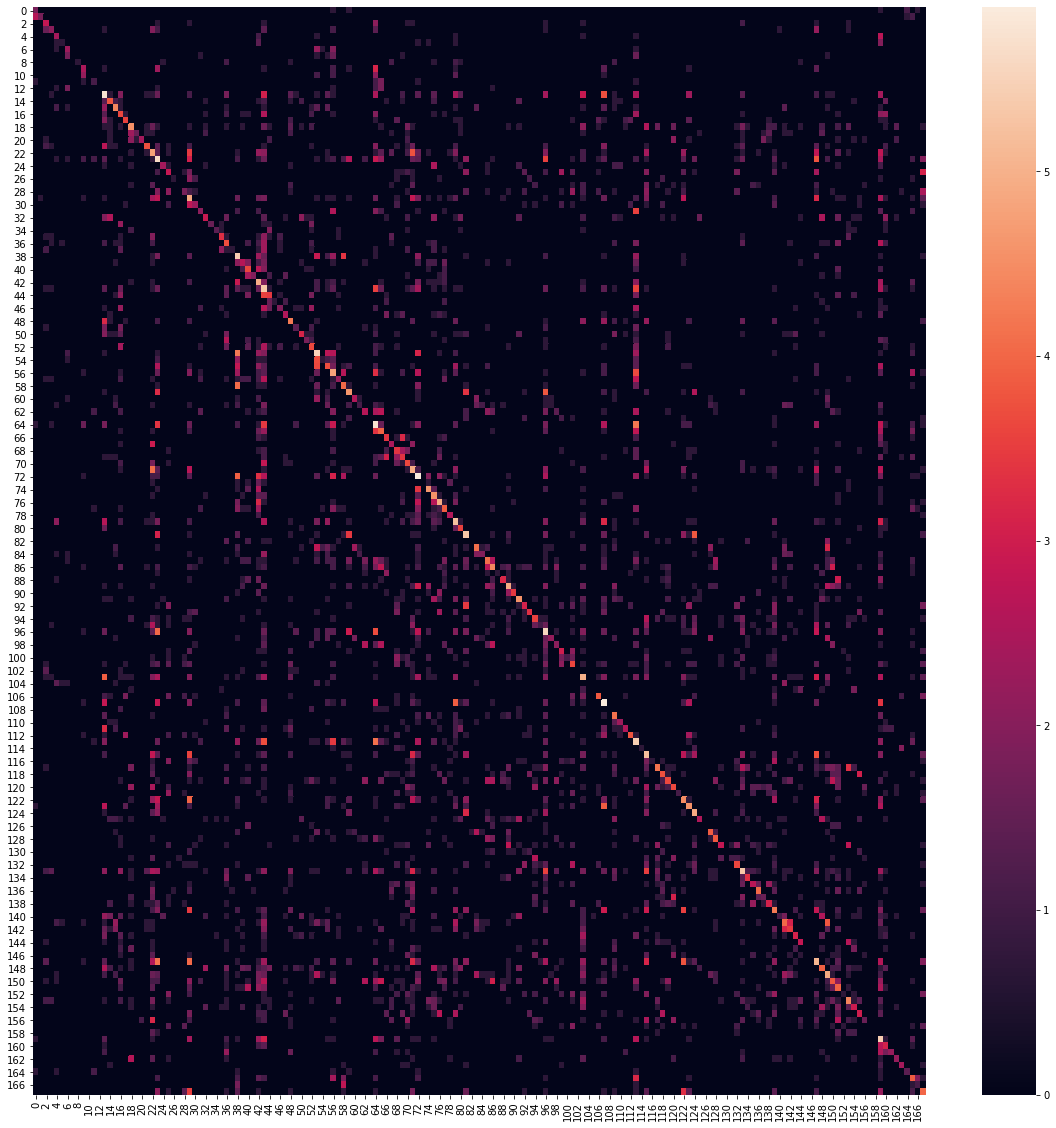

6.602764149098973 3.8476545051276507 1.3744650585672498 1.3806445854040725


2.944325229544549 (1.3907968876468149, 0.747285533103214, 0.8062428087945197)
0.6625463717795588
0.9071253498371774
0.8554966948054906
[[4023  113    6   14   52    7   17   14    1    1    0]
 [  94 3522    2   19    1    1    3    3    0   16    1]
 [  13    3 2557    2    0    0    0    2    0    0    0]
 [   6   33    0 1538    0    0    0    0    0    0    2]
 [ 174    7    1    1 1678    7   10    3    0    0    0]
 [  76   17    0    0   92  316   20    1    0    0    0]
 [  44    0    0    0   14    5  385    0    0    0    0]
 [  38    2   14    1    0    0    0 2711   30   62    1]
 [   1    1    2    0    0    0    0   15  306    6    2]
 [   0   27    0    0    0    0    0   35    3 1527   26]
 [   1    1    0    1    0    0    0    3    1   16  334]]
[[12135    12   218     0    98    91     1]
 [   37   616    39     0     1     0     0]
 [  138     7  2151     2     1     9     0]
 [    0     0     3    55     4     0     0]
 [  108     0    14     7  2010     0     8]
 

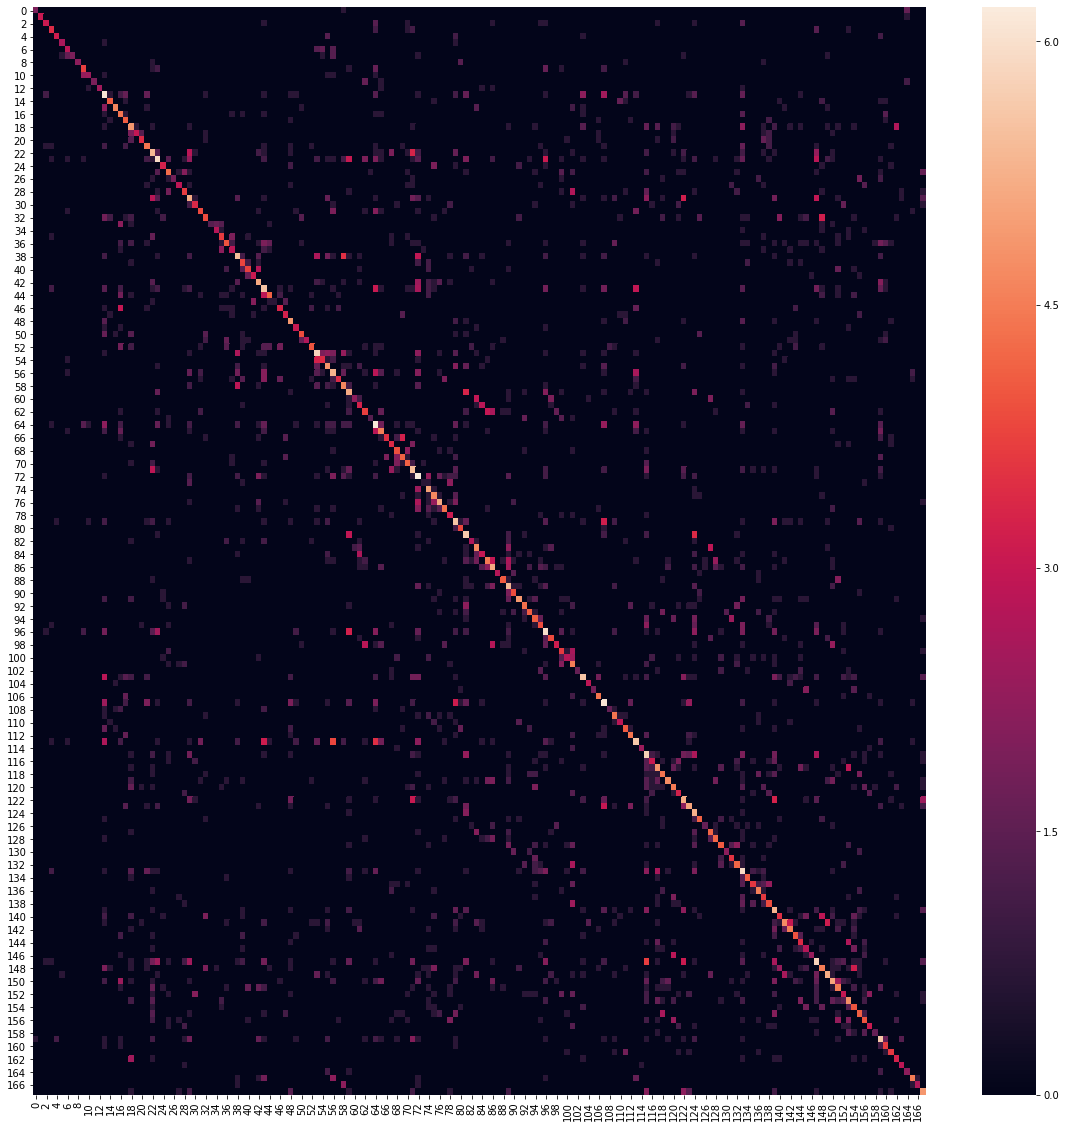

5.855961755139638 3.359303946516155 1.2508803147130307 1.245777493910452


2.545146454101915 (1.1297923508723071, 0.7015854547357863, 0.7137686484938215)
0.7708148715182532
0.9223522991736872
0.9351009799396085
[[4083  113    1    7   30    5    0    9    0    0    0]
 [  63 3565    0   25    0    2    1    0    0    6    0]
 [  36    3 2529    2    0    0    0    5    2    0    0]
 [   3   26    0 1549    0    0    0    0    0    0    1]
 [ 143    6    0    1 1705   23    2    1    0    0    0]
 [  44    5    0    0   29  436    8    0    0    0    0]
 [  58    1    0    0    8   20  361    0    0    0    0]
 [  51    1    1    0    0    0    0 2760   11   35    0]
 [   2    3    1    0    0    0    0   18  304    3    2]
 [   0   45    0    0    0    0    0   47    2 1513   11]
 [   1    2    0    8    0    0    0   12    0   17  317]]
[[12102     3   149     0   114   186     1]
 [   37   638    17     0     1     0     0]
 [  134     5  2150     6     1    11     1]
 [    0     0     1    57     4     0     0]
 [   53     0    12     3  2059     2    18]


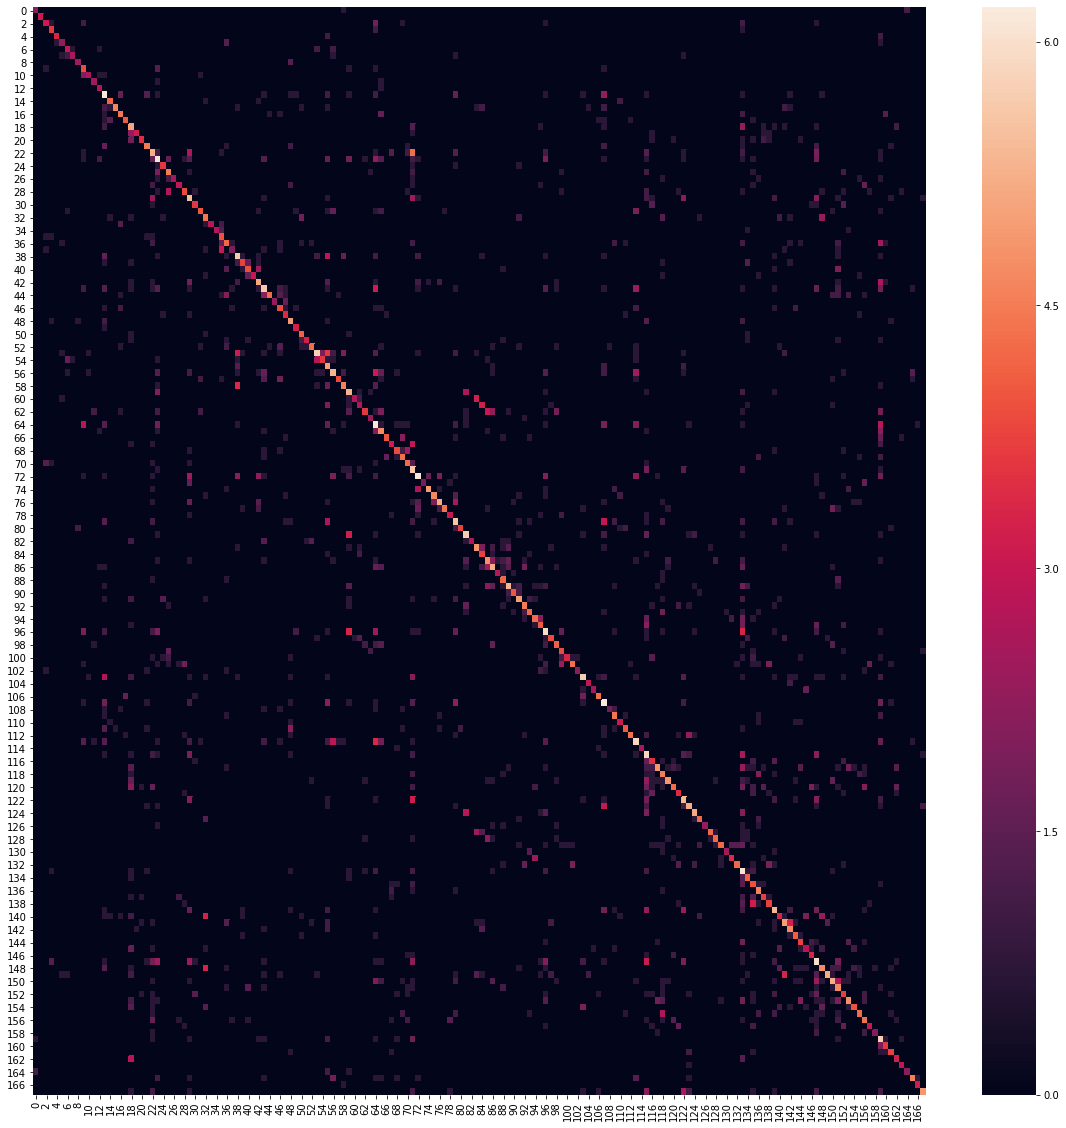

5.3317618320389135 3.0153822846201668 1.167090499515027 1.1492890479037192


2.2651980031447807 (0.9532284611349653, 0.6725364805786473, 0.639433061431168)
0.8469494552134227
0.952309843929418
0.9351313658935071
[[4086   39    6    1   63   19   19   13    2    0    0]
 [ 158 3453    3   24    1    8    4    1    0   10    0]
 [   4    0 2570    1    0    0    0    1    1    0    0]
 [  11   20    0 1547    0    0    0    0    0    0    1]
 [  48    1    0    0 1805   14   12    1    0    0    0]
 [  14    2    0    0   25  468   13    0    0    0    0]
 [  15    0    0    0    2   12  419    0    0    0    0]
 [  12    0    4    0    0    0    0 2799   17   27    0]
 [   0    0    6    0    0    0    0    8  317    1    1]
 [   0   16    2    0    0    0    0   49    4 1532   15]
 [   0    1    1    0    0    0    0    9    0   16  330]]
[[12351    16    44     0    25   119     0]
 [   14   673     5     0     1     0     0]
 [  182    23  2086     3     0    14     0]
 [    0     0     1    53     8     0     0]
 [   92     0     7     0  2027     1    20]
 

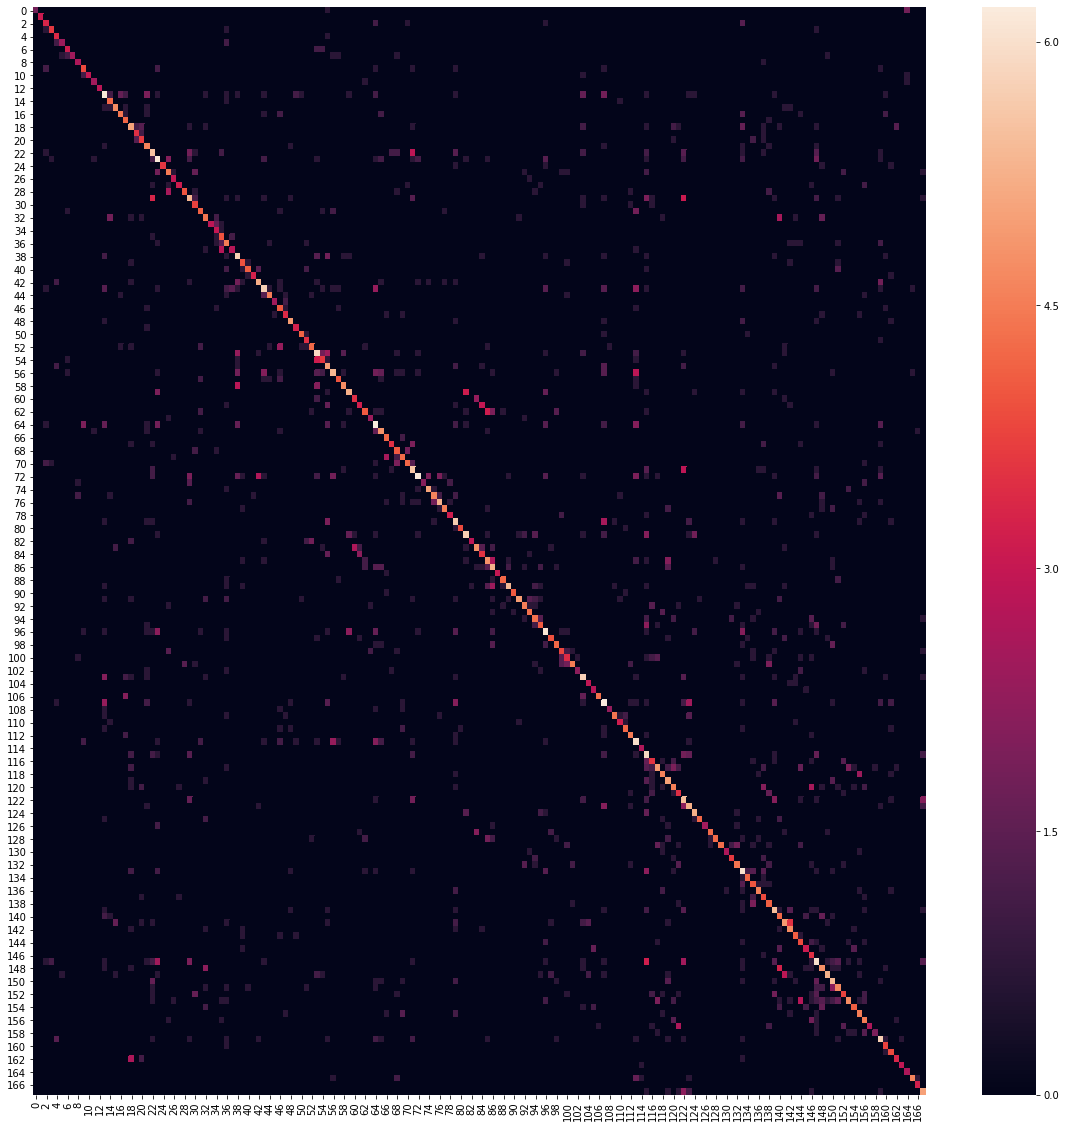

4.942974498982275 2.760197945590568 1.10630011065168 1.0764764427400269


2.1547660920650333 (0.8878428822110414, 0.6642529725269147, 0.6026702373270776)
0.879668096128516
0.9430994590257771
0.9457652740303978
[[4176   37    1    6   19    3    0    6    0    0    0]
 [  73 3551    1   26    2    1    2    0    0    6    0]
 [   7    0 2568    1    0    0    0    1    0    0    0]
 [   2   10    0 1566    0    0    0    0    0    0    1]
 [ 148    1    0    0 1718    5    8    1    0    0    0]
 [  71    1    0    0   19  414   17    0    0    0    0]
 [  38    0    0    0    2    0  408    0    0    0    0]
 [  45    1    9    0    1    0    0 2772    8   21    2]
 [   5    0    5    0    0    0    0   10  310    1    2]
 [   1   32    2    0    0    0    0   28    2 1531   22]
 [   1    0    0    2    0    0    0    3    0    5  346]]
[[12359     1    53     0    18   124     0]
 [   34   639    16     0     1     3     0]
 [  129     0  2169     0     0    10     0]
 [    0     0     2    58     2     0     0]
 [   92     0    13     0  2021     0    21]


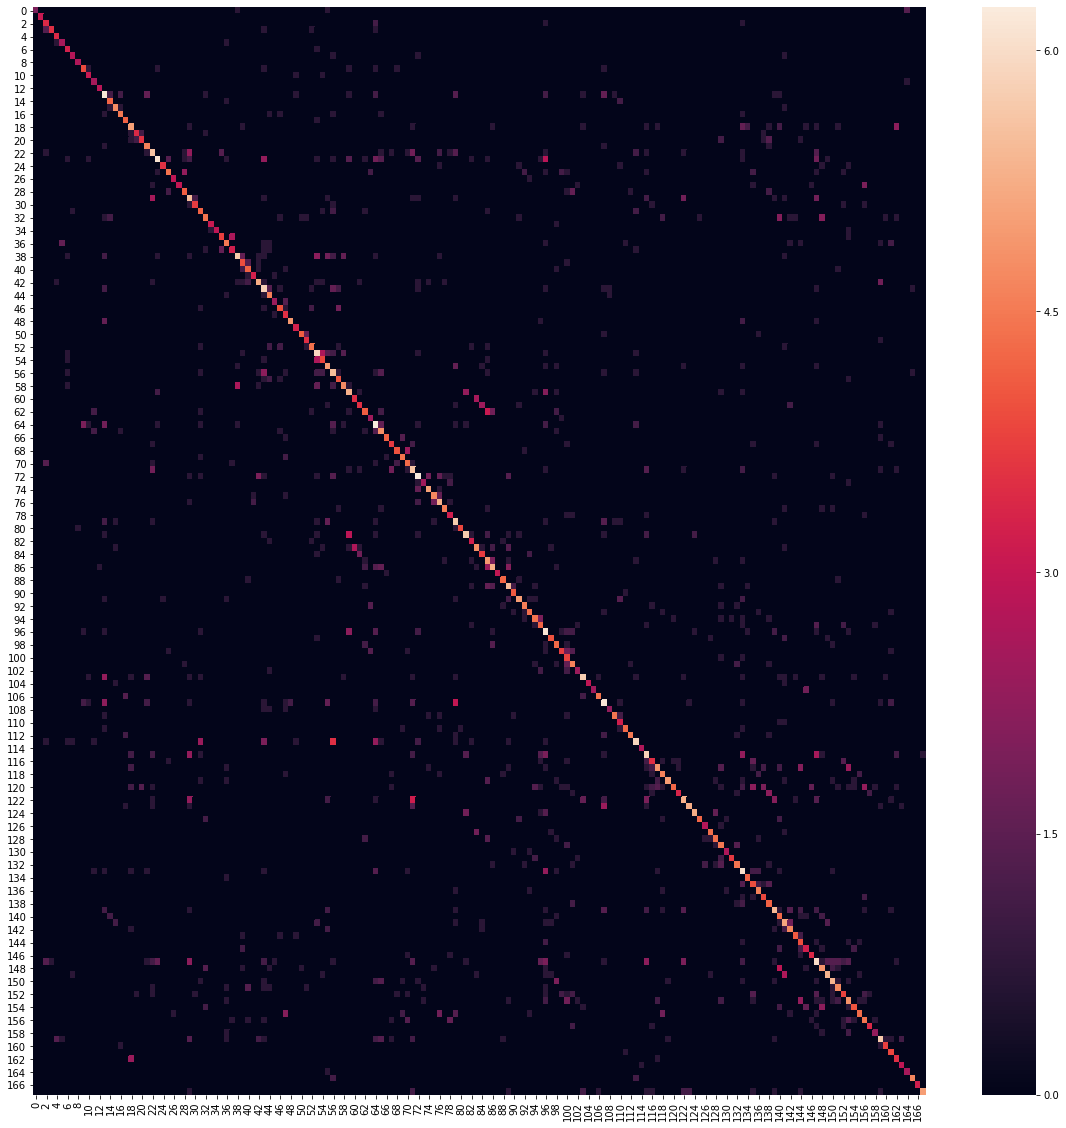

4.643559021184176 2.563634828583781 1.0598088421863792 1.0201153504140157


2.0949451378576316 (0.8629587998815403, 0.6353020759145166, 0.5966842620615747)
0.8864708271527432
0.9611079340868997
0.9512251662689727
[[4113   62    5    5   44    1    5   13    0    0    0]
 [  40 3590    2   12    2    0    1    1    0   14    0]
 [   4    0 2571    1    0    0    0    0    1    0    0]
 [   4   18    0 1555    0    0    0    0    0    0    2]
 [  53    3    0    0 1815    3    6    1    0    0    0]
 [  32    1    0    0   25  451   13    0    0    0    0]
 [  15    0    0    0    5    2  426    0    0    0    0]
 [  10    0   12    1    0    0    0 2791    7   35    3]
 [   0    1    3    0    0    0    0   11  312    4    2]
 [   0   11    1    0    0    0    0   18    3 1575   10]
 [   0    0    0    0    0    0    0    1    0    8  348]]
[[12211    35   189     0    57    63     0]
 [    6   678     8     0     1     0     0]
 [   54    10  2241     1     0     2     0]
 [    0     0     1    60     1     0     0]
 [   46     0     2     1  2093     0     5]

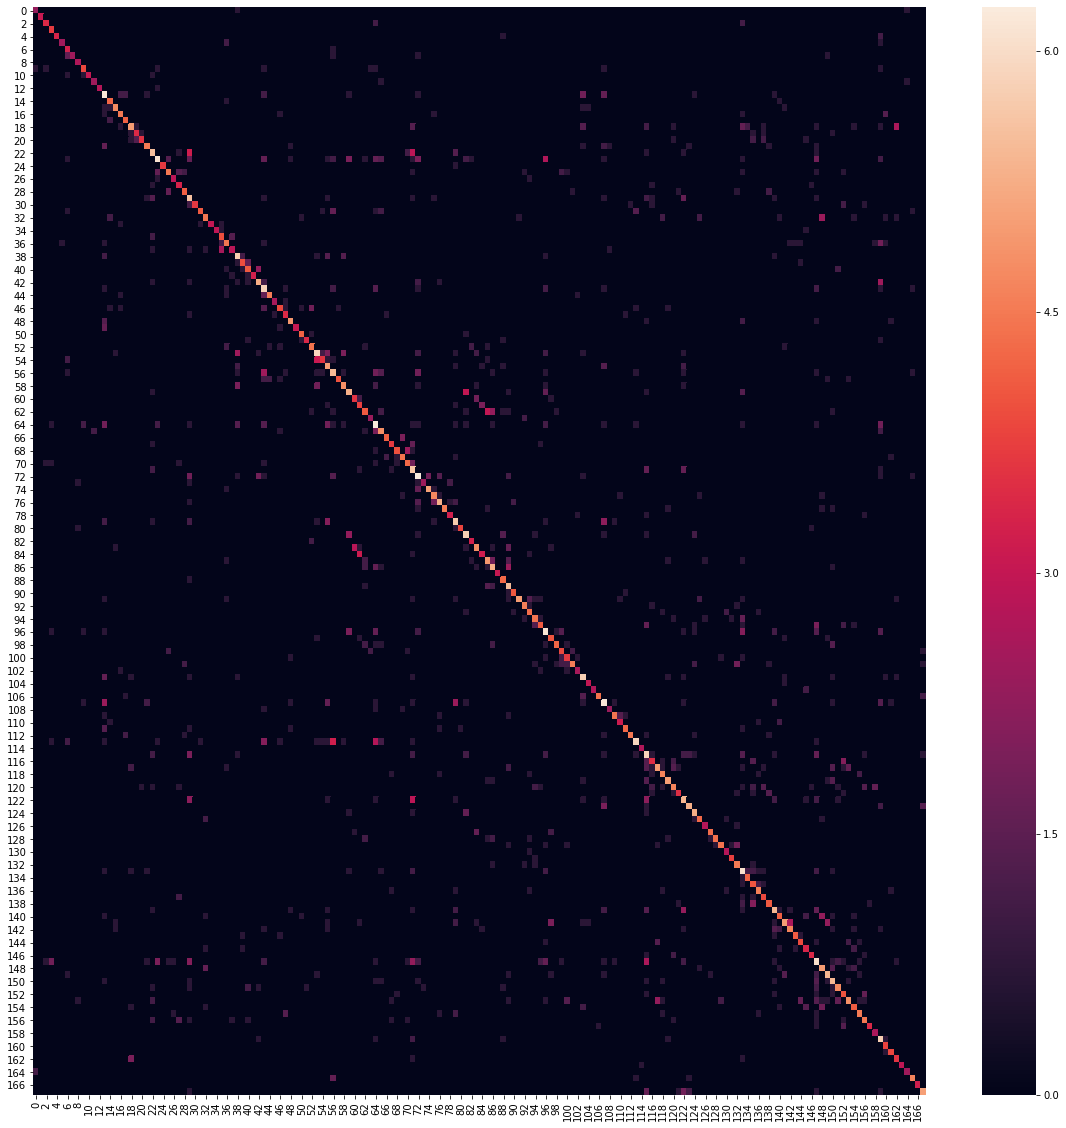

4.405051699164694 2.4066195387966864 1.023181097106596 0.9752510632614119


2.075812234050909 (0.8606242482449599, 0.6380266416224705, 0.5771613441834784)
0.8974011212452284
0.9569297839730634
0.947262865613152
[[4087   31    1    0   89    8    4   26    1    1    0]
 [  71 3559    1    6    4    1    2    1    0   17    0]
 [   5    0 2560    1    0    0    0    9    2    0    0]
 [   6   32    0 1535    0    0    0    0    0    1    5]
 [  38    0    0    0 1836    2    4    1    0    0    0]
 [  20    0    0    0   30  465    6    1    0    0    0]
 [  10    0    0    0    8   14  415    1    0    0    0]
 [   4    0    1    0    0    0    0 2830    6   17    1]
 [   0    0    0    0    0    0    0   13  319    1    0]
 [   0    4    0    0    0    0    0   41    0 1569    4]
 [   0    1    0    0    0    0    0    6    0   23  327]]
[[12446    13    23     0    15    58     0]
 [   12   676     4     0     1     0     0]
 [  179     8  2109     1     3     8     0]
 [    0     0     1    58     3     0     0]
 [   98     0     0     0  2041     0     8]
 

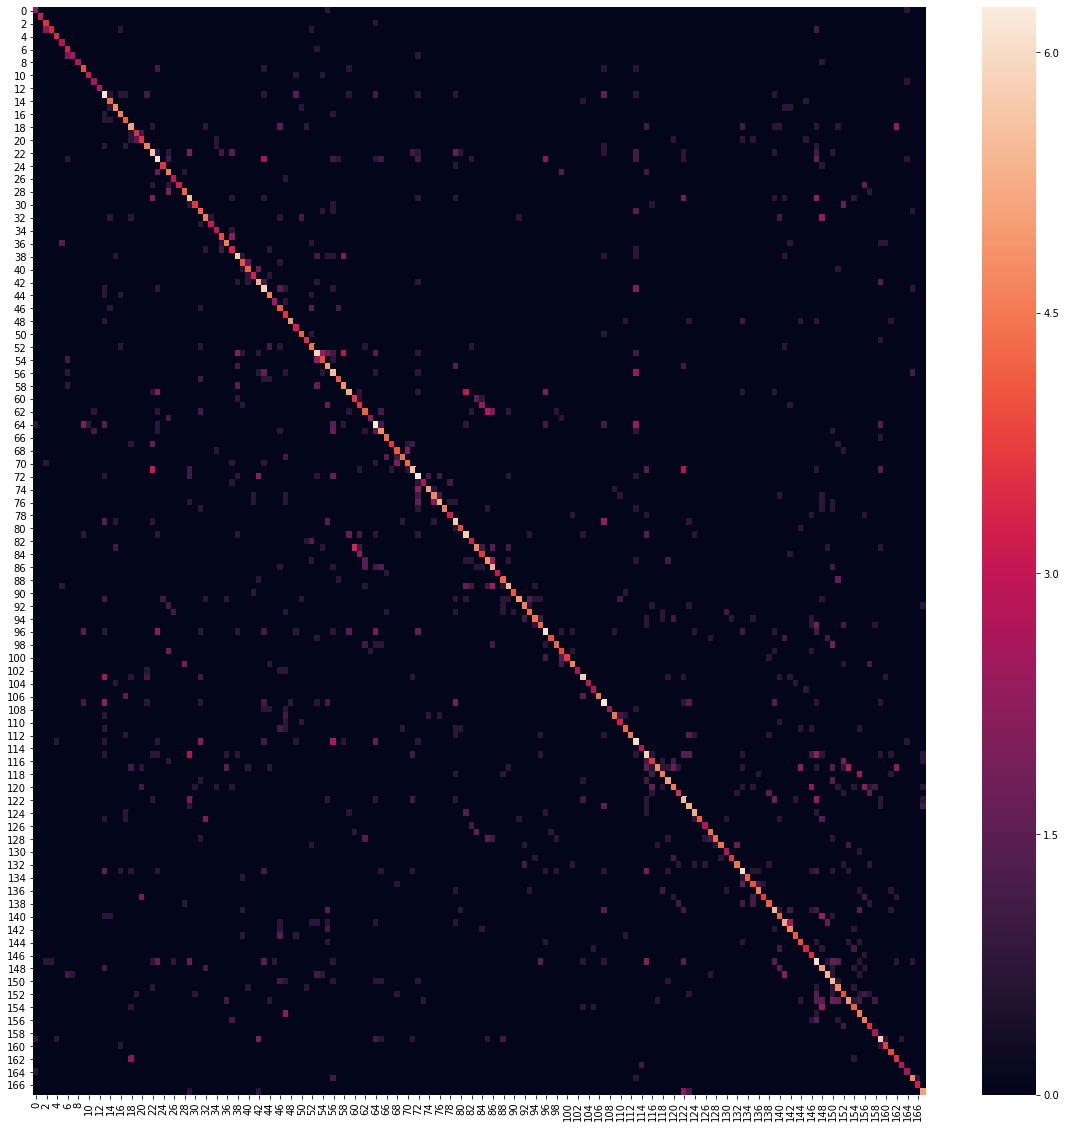

4.210793515562191 2.2781669965981264 0.993682618237292 0.9389439007267723


2.0277782524846923 (0.8249023858528988, 0.6318334481518739, 0.5710424184799194)
0.9058786516898468
0.9628113057647387
0.9523214168677042
[[4097   52    4    6   45    6    1   35    0    2    0]
 [  31 3578    1   24    2    0    1    1    0   24    0]
 [   2    0 2570    1    0    0    0    2    2    0    0]
 [   1   12    0 1563    0    0    0    0    0    0    3]
 [  36    0    0    0 1840    2    1    2    0    0    0]
 [  19    3    0    0   22  474    2    2    0    0    0]
 [  23    1    0    0    3   28  392    1    0    0    0]
 [   5    0    3    0    0    0    0 2806   11   30    4]
 [   0    0    1    0    0    0    0    6  322    1    3]
 [   0    3    0    0    0    0    0   21    0 1573   21]
 [   0    0    0    0    0    0    0    2    0    5  350]]
[[12411     1    22     0    28    93     0]
 [   27   653    10     0     1     2     0]
 [  179     2  2114     1     3     9     0]
 [    0     0     1    59     2     0     0]
 [   62     0     1     0  2077     0     7]

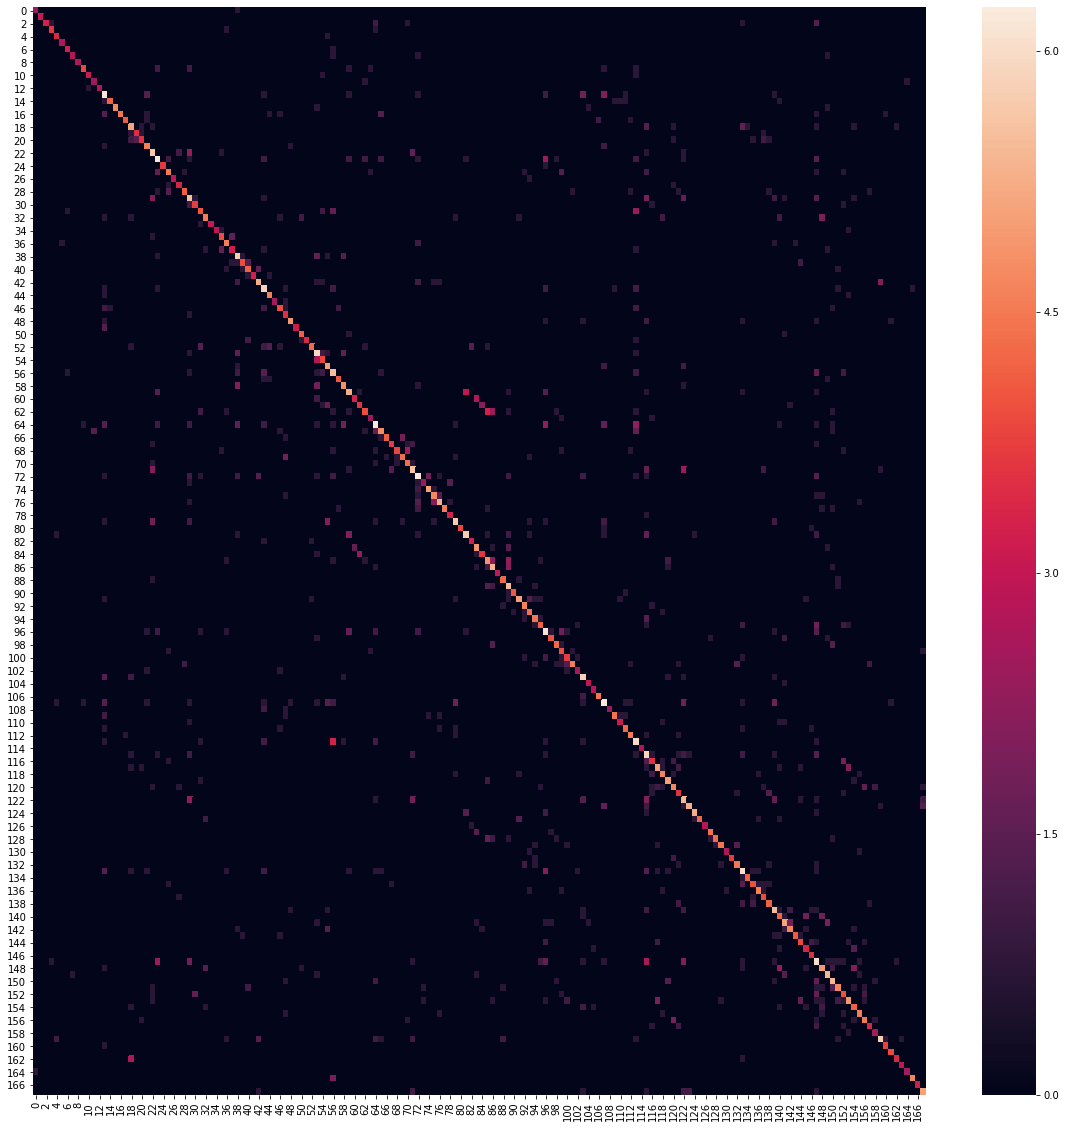

4.04799377572642 2.1702352799018927 0.9691452197627684 0.9086132760617586


2.0139307299996636 (0.8263533405817238, 0.6234168078109716, 0.5641605816069682)
0.9155958533762076
0.9666921599392077
0.964688975212525
[[4137   67    2    5   19    8    5    5    0    0    0]
 [  27 3612    0   14    0    1    1    0    0    7    0]
 [   5    2 2567    1    0    0    0    1    1    0    0]
 [   1   11    0 1566    0    0    0    0    0    0    1]
 [  49    4    0    0 1820    2    5    1    0    0    0]
 [  18    2    0    0   19  479    4    0    0    0    0]
 [  11    0    0    0    2   13  422    0    0    0    0]
 [  15    0    3    0    0    0    1 2792    9   38    1]
 [   0    0    1    0    0    0    0   11  318    1    2]
 [   0   36    1    0    0    0    0   14    3 1554   10]
 [   0    0    0    1    0    0    0    2    0    9  345]]
[[12376    11    58     0    15    95     0]
 [    7   678     7     0     1     0     0]
 [   83     7  2211     0     1     6     0]
 [    0     0     2    60     0     0     0]
 [   46     0     4     0  2085     4     8]


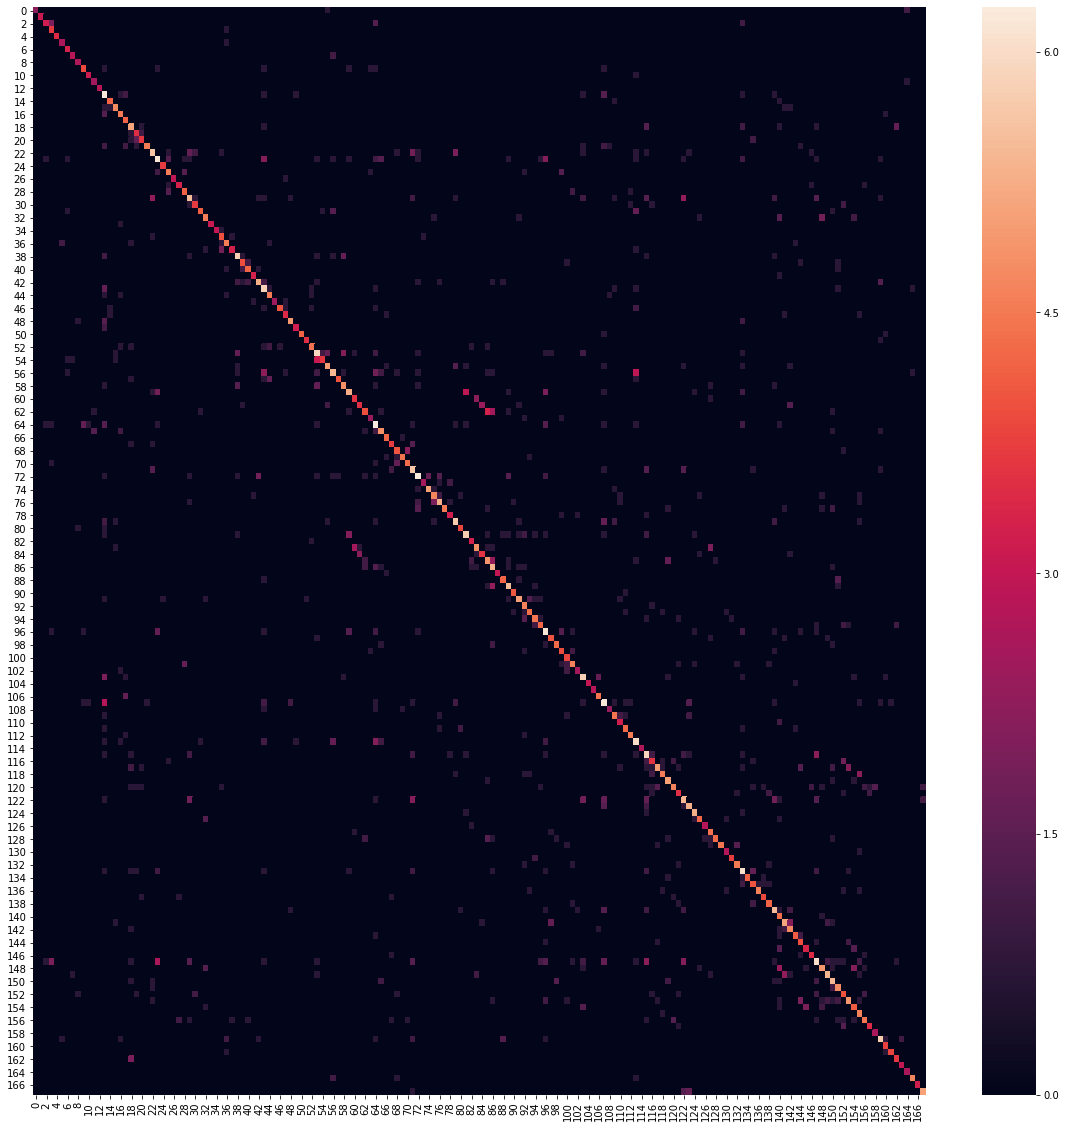

3.9105315264078846 2.079009608175135 0.9483150807888586 0.8832068374438911


2.090656695472207 (0.8851324676708051, 0.6269116762337411, 0.5786125515676608)
0.8899458064598293
0.9647434580232921
0.9343112109223574
[[4162   42    4    3   23    4    4    6    0    0    0]
 [  44 3591    1   10    0    1    1    1    0   13    0]
 [   3    0 2572    1    0    0    0    0    1    0    0]
 [   2   12    0 1562    0    0    0    0    0    0    3]
 [  68    1    0    0 1803    2    7    0    0    0    0]
 [  34    3    0    0   15  457   13    0    0    0    0]
 [  19    2    0    0    1    2  424    0    0    0    0]
 [  14    0    3    0    0    0    0 2783   16   42    1]
 [   0    0    2    0    0    0    0    6  320    3    2]
 [   0    6    0    0    0    0    0   12    0 1591    9]
 [   0    0    0    0    0    0    0    1    0   11  345]]
[[12460     1    10     0    53    30     1]
 [   19   665     7     0     2     0     0]
 [  238     1  2048     8     3    10     0]
 [    0     0     0    56     6     0     0]
 [   34     0     0     0  2111     0     2]


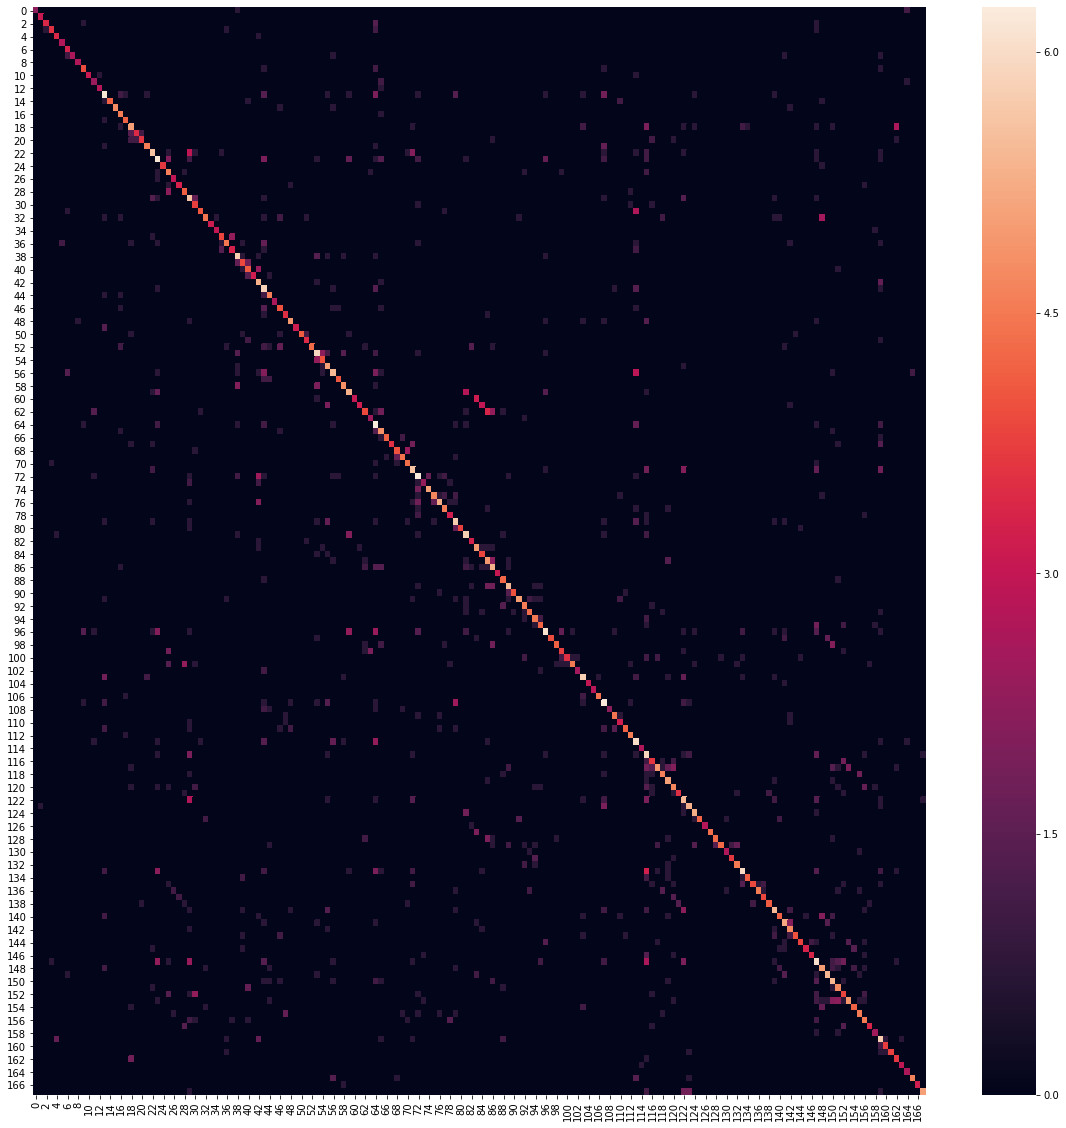

3.79190418261694 1.9998924256355712 0.9304986148562755 0.8615131421250931


2.056250837388312 (0.8783133821502612, 0.6160460769370862, 0.5618913783009645)
0.9105119808108691
0.9714903181954913
0.9527849390718105
[[4151   39    1    2   33    7    5    9    1    0    0]
 [  38 3600    1    9    1    1    2    1    0    9    0]
 [   3    1 2570    1    0    0    0    1    1    0    0]
 [   2   10    0 1566    0    0    0    0    0    0    1]
 [  29    1    0    0 1844    2    4    1    0    0    0]
 [  14    0    0    0   25  469   14    0    0    0    0]
 [  11    0    0    0    3    3  431    0    0    0    0]
 [  11    0    5    0    0    0    0 2801   17   24    1]
 [   0    0    2    0    0    0    0    7  321    1    2]
 [   0    9    0    0    0    0    0   25    2 1573    9]
 [   0    0    0    0    0    0    0    1    0    6  350]]
[[12404     5    29     0    51    65     1]
 [   11   674     8     0     0     0     0]
 [  124     0  2174     1     2     7     0]
 [    0     0     1    57     4     0     0]
 [   37     0     0     0  2105     0     5]


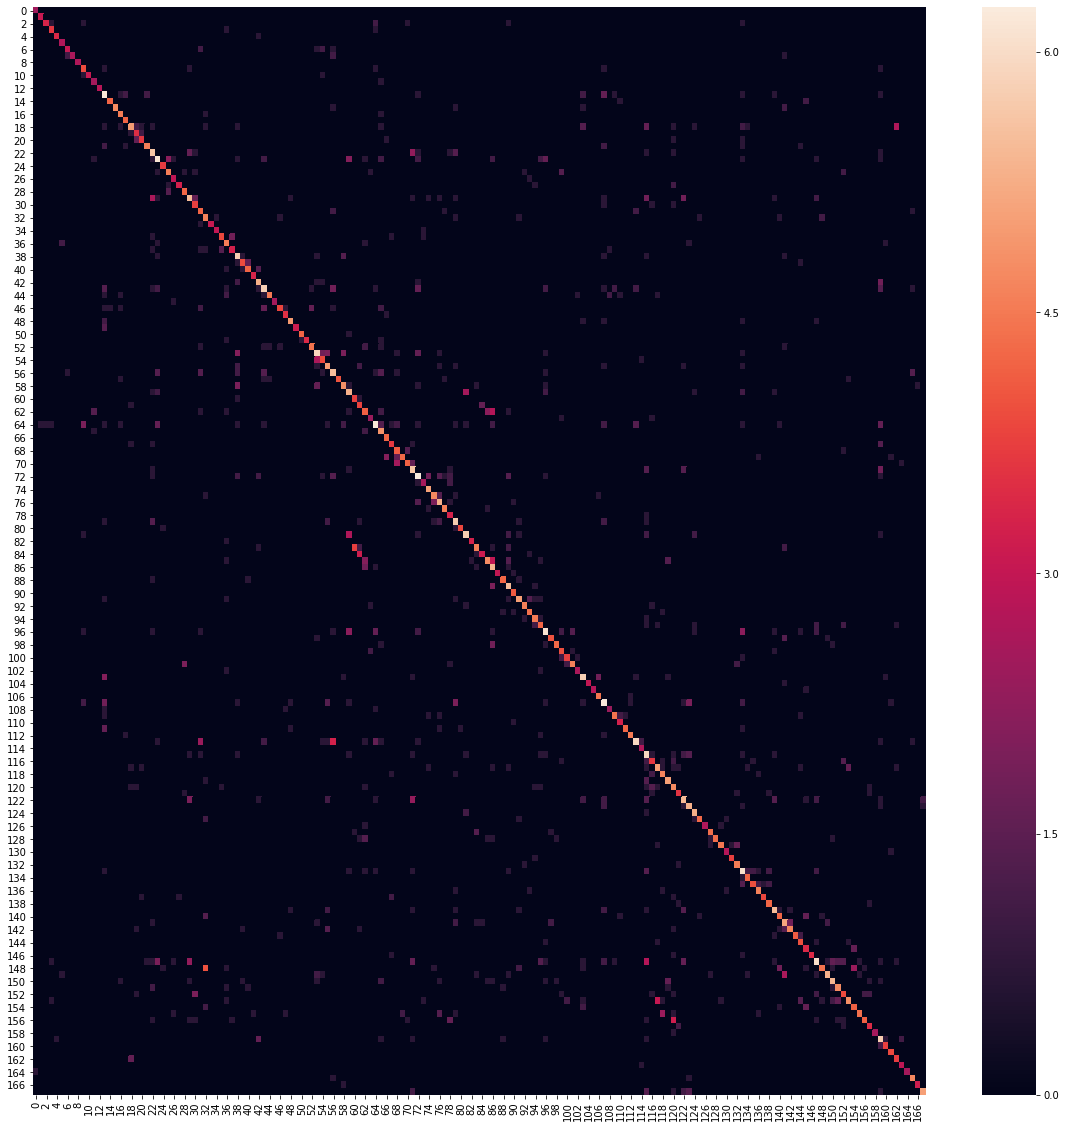

3.6889810714354883 1.9311854777131623 0.9149534436015551 0.8428421501207709


2.0464353646822038 (0.8612674491800321, 0.6213200834526378, 0.5638478320495338)
0.9120563543100632
0.9689900660361036
0.9675783504202136
[[4097   91    2    2   35    6    2   13    0    0    0]
 [  15 3627    1    4    0    1    1    0    0   13    0]
 [   4    0 2572    1    0    0    0    0    0    0    0]
 [   1   15    0 1562    0    0    0    0    0    1    0]
 [  39    2    1    0 1830    5    2    2    0    0    0]
 [  17    4    0    0   14  478    9    0    0    0    0]
 [   9    0    0    0    2    7  430    0    0    0    0]
 [   8    0    2    1    0    0    0 2796    6   43    3]
 [   0    0    3    0    0    0    0    8  318    2    2]
 [   0    6    0    0    0    0    0   12    0 1595    5]
 [   0    0    0    0    0    0    0    3    0   15  339]]
[[12300     4    76     1    42   130     2]
 [   12   672     7     0     2     0     0]
 [   76     2  2219     1     4     6     0]
 [    0     0     1    60     1     0     0]
 [   51     0     0     0  2085     1    10]

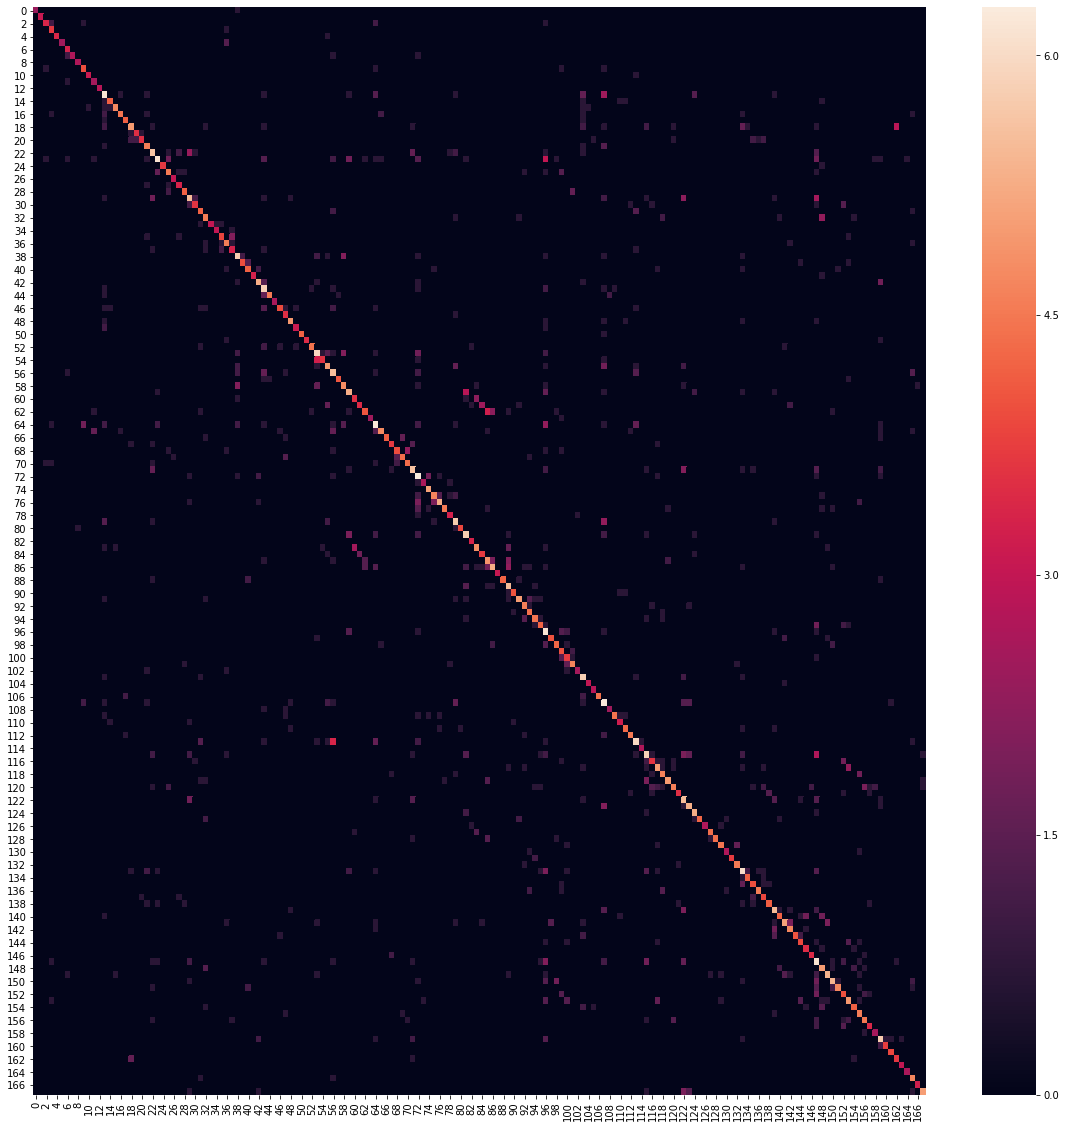

3.5988862537448534 1.8708909262040472 0.9013750561887184 0.8266202713520879


2.013675644519223 (0.8327409645934014, 0.617516675192839, 0.5634180047329823)
0.9200318345975111
0.9687545964414127
0.9719424316206078
[[4172   32    1    1   17    6    9   10    0    0    0]
 [  49 3594    1    6    0    2    2    1    0    7    0]
 [   6    0 2567    1    0    0    0    2    1    0    0]
 [   6   14    0 1557    0    0    1    0    0    0    1]
 [  50    1    0    0 1817    6    7    0    0    0    0]
 [  18    0    0    0   11  486    7    0    0    0    0]
 [   8    0    0    0    1    8  431    0    0    0    0]
 [  12    0    1    0    0    0    0 2828    5   12    1]
 [   0    0    2    0    0    0    0   12  316    1    2]
 [   0    7    0    0    0    0    0   39    2 1564    6]
 [   0    1    0    1    0    0    0    6    0   11  338]]
[[12288     9    55     0    26   175     2]
 [    8   679     5     0     0     1     0]
 [   92     3  2207     0     1     5     0]
 [    0     0     1    61     0     0     0]
 [   39     0     2     1  2090     2    13]
 

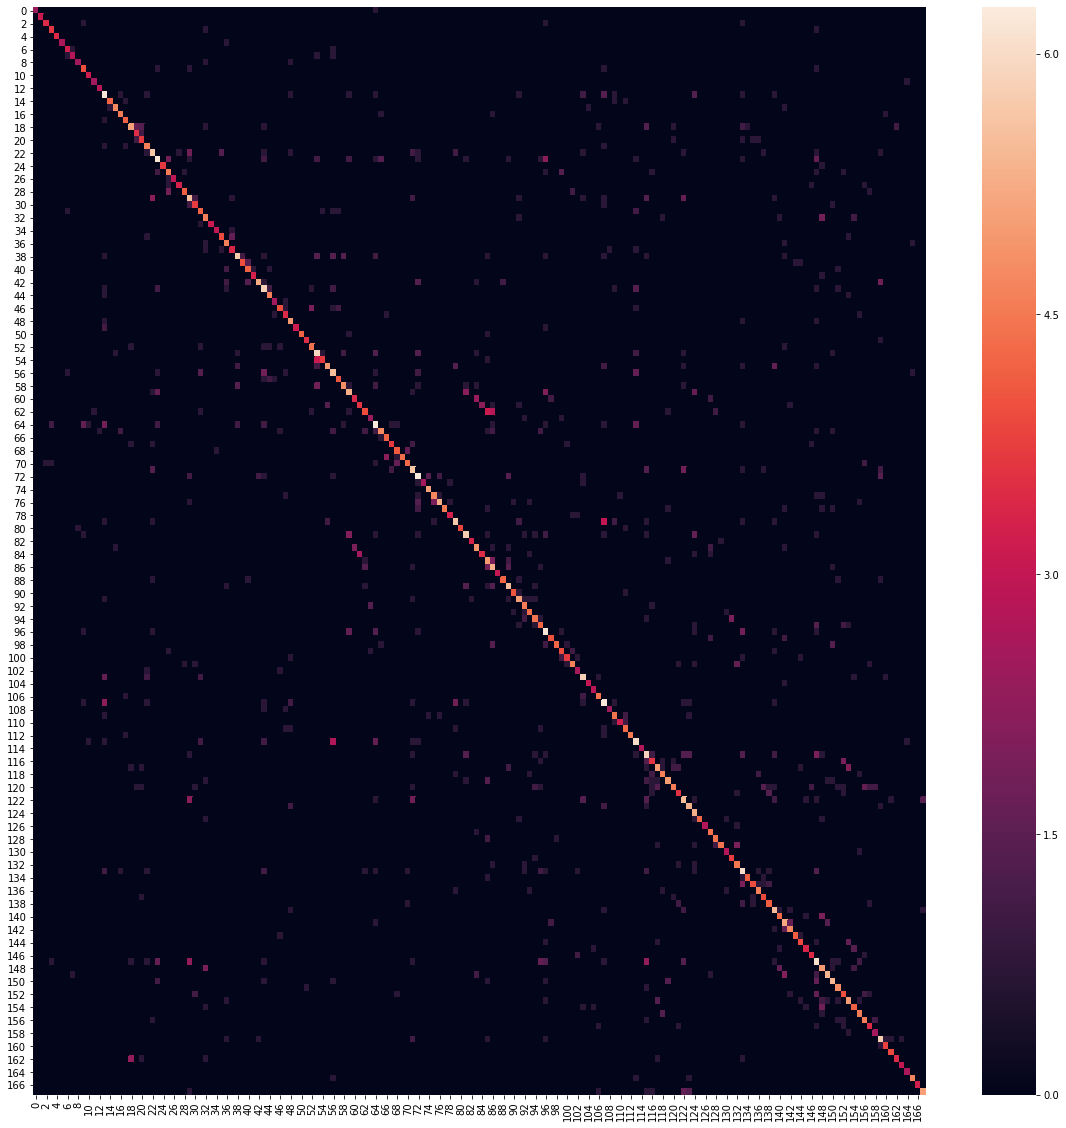

3.5193385229181047 1.8175871254589002 0.8893651217232763 0.8123862757359283


2.0112773495115293 (0.838017541511803, 0.6158713854042588, 0.5573884225954675)
0.9212105798340966
0.9673715788398684
0.9668475224446939
[[4165   40    1    2   18   10    0   12    0    0    0]
 [  41 3595    0   14    2    0    2    0    0    8    0]
 [   8    0 2564    2    0    0    0    2    1    0    0]
 [   5   10    0 1564    0    0    0    0    0    0    0]
 [  49    1    0    0 1824    2    4    1    0    0    0]
 [  12    2    0    0   24  478    6    0    0    0    0]
 [  12    0    0    0    2    8  426    0    0    0    0]
 [  13    0    2    0    0    0    0 2823    3   17    1]
 [   1    1    6    0    0    0    0   16  308    1    0]
 [   0    8    0    1    0    0    0   25    2 1565   17]
 [   0    1    0    1    0    0    0    2    0    4  349]]
[[12444     2    35     0    13    60     1]
 [   12   674     6     0     1     0     0]
 [  118     2  2183     0     1     4     0]
 [    0     0     1    61     0     0     0]
 [   57     0     2     0  2078     0    10]


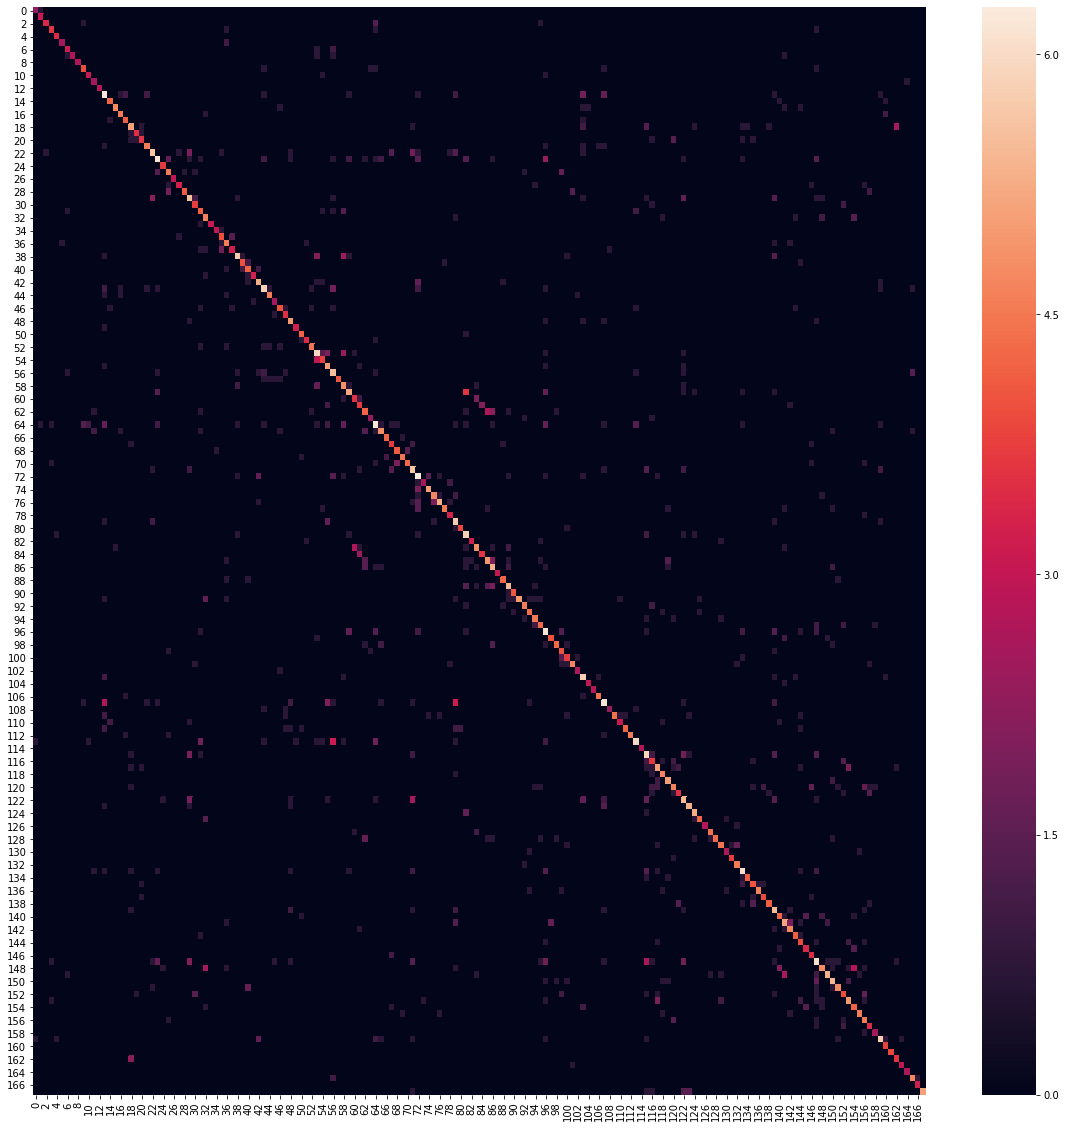

In [30]:
run_epochs(15)

In [0]:
torch.save(model.state_dict(),'/content/gdrive/My Drive/r50_labelsmooth.pth')

In [0]:
for p in model.vowel_diac_predictor.parameters():
  p.requires_grad=False

for p in model.consonant_diacs.parameters():
  p.requires_grad=False


In [0]:
model.freeze()

2.836479634806118 1.3862035905025467 0.7409058206036848 0.7093702236998867


2.0304141111054994 (0.7859768081622519, 0.6487852458361607, 0.5956520571070871)
0.9343357836100574
0.9466212963308359
0.9720615683735946
[[4145   52    2    4   25   10    2    8    0    0    0]
 [ 101 3545    0    4    0    2    2    1    0    7    0]
 [   5    1 2570    1    0    0    0    0    0    0    0]
 [   3   57    0 1518    0    0    0    0    0    0    1]
 [  42    0    0    0 1831    3    3    2    0    0    0]
 [  12    1    0    0   20  483    6    0    0    0    0]
 [  23    0    0    0    2    7  416    0    0    0    0]
 [   7    1    8    0    0    0    0 2661    8  173    1]
 [   0    0    8    0    0    0    0   11  310    4    0]
 [   0    6    0    0    0    0    0    7    2 1601    2]
 [   0    1    0    0    0    0    0    0    1   58  297]]
[[11993    60   287     0    73   142     0]
 [    4   682     4     0     3     0     0]
 [   32    16  2240    18     0     2     0]
 [    0     0     0    62     0     0     0]
 [   37     0     4     3  2098     2     3]

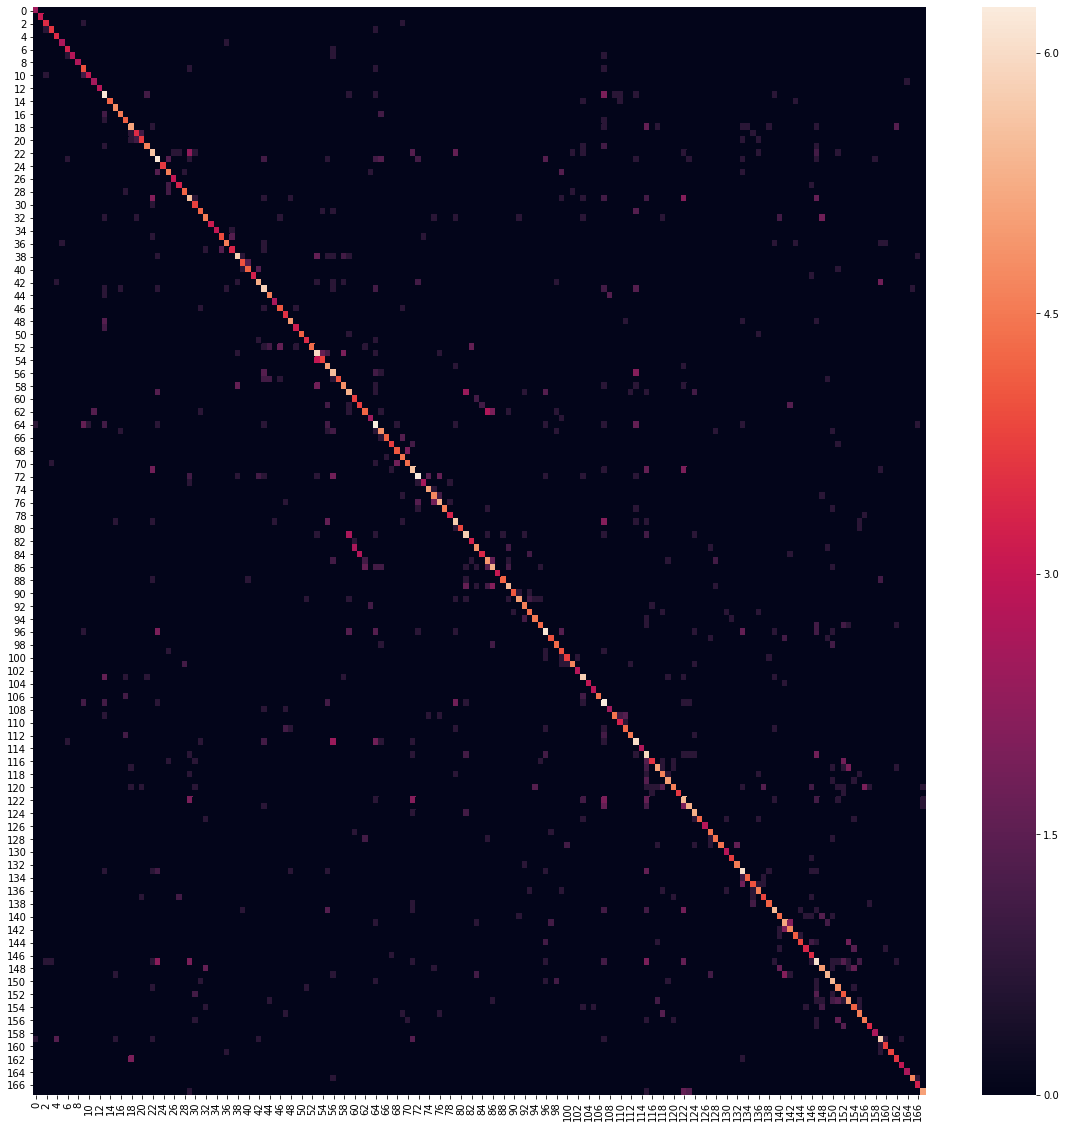

2.735518016135798 1.309273047101181 0.7304348737708235 0.6958100952637934


2.0133748196872174 (0.782469785137541, 0.6475026051329958, 0.5834024294166807)
0.9384398988616921
0.9502411870295991
0.9681869690945588
[[4123   52    3    5   37   10    4   13    0    1    0]
 [  91 3550    0    5    0    2    3    1    0   10    0]
 [   5    0 2570    1    0    0    0    0    0    1    0]
 [   4   46    0 1528    0    0    0    0    0    0    1]
 [  37    0    0    0 1835    3    4    2    0    0    0]
 [  11    0    0    0   21  482    8    0    0    0    0]
 [  19    0    0    0    3    5  421    0    0    0    0]
 [   6    0    8    0    0    0    0 2658   10  175    2]
 [   0    0    6    0    0    0    0   11  311    4    1]
 [   0    5    0    0    0    0    0    9    2 1599    3]
 [   0    1    0    0    0    0    0    0    1   49  306]]
[[12108    63   231     0    33   120     0]
 [    5   683     4     0     1     0     0]
 [   35    17  2250     3     0     3     0]
 [    0     0     1    61     0     0     0]
 [   72     0     6     2  2063     2     2]


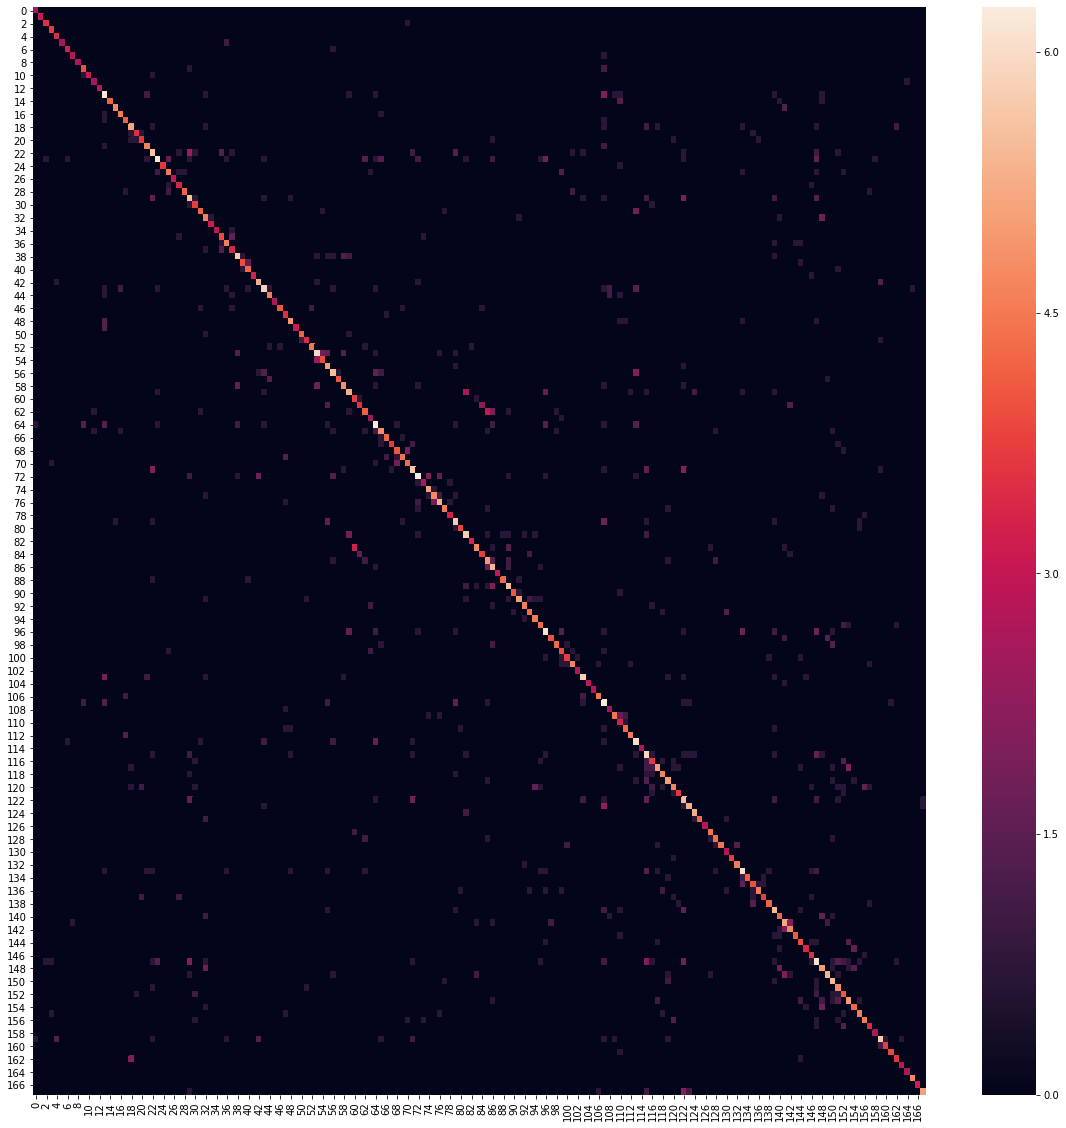

2.651599990347174 1.2448891379309583 0.721967865806957 0.6847429866092587


2.004595946354471 (0.776916690123309, 0.6479501866610946, 0.5797290695700675)
0.9395346963551412
0.9503942664639904
0.9721722437489035
[[4147   47    2    5   27    8    3    8    0    1    0]
 [ 103 3541    0    5    0    2    2    1    0    8    0]
 [   5    1 2570    1    0    0    0    0    0    0    0]
 [   3   46    0 1529    0    0    0    0    0    0    1]
 [  39    0    0    0 1834    3    3    2    0    0    0]
 [  13    0    0    0   20  481    8    0    0    0    0]
 [  24    0    0    0    2    3  419    0    0    0    0]
 [   7    1    8    0    0    0    0 2647   10  183    3]
 [   0    0    8    0    0    0    0   11  309    4    1]
 [   0    6    0    0    0    0    0    7    2 1600    3]
 [   0    1    0    0    0    0    0    0    1   44  311]]
[[12123    43   234     0    45   110     0]
 [    5   681     5     0     2     0     0]
 [   34    15  2250     7     0     2     0]
 [    0     0     0    62     0     0     0]
 [   57     0     5     2  2079     2     2]
 

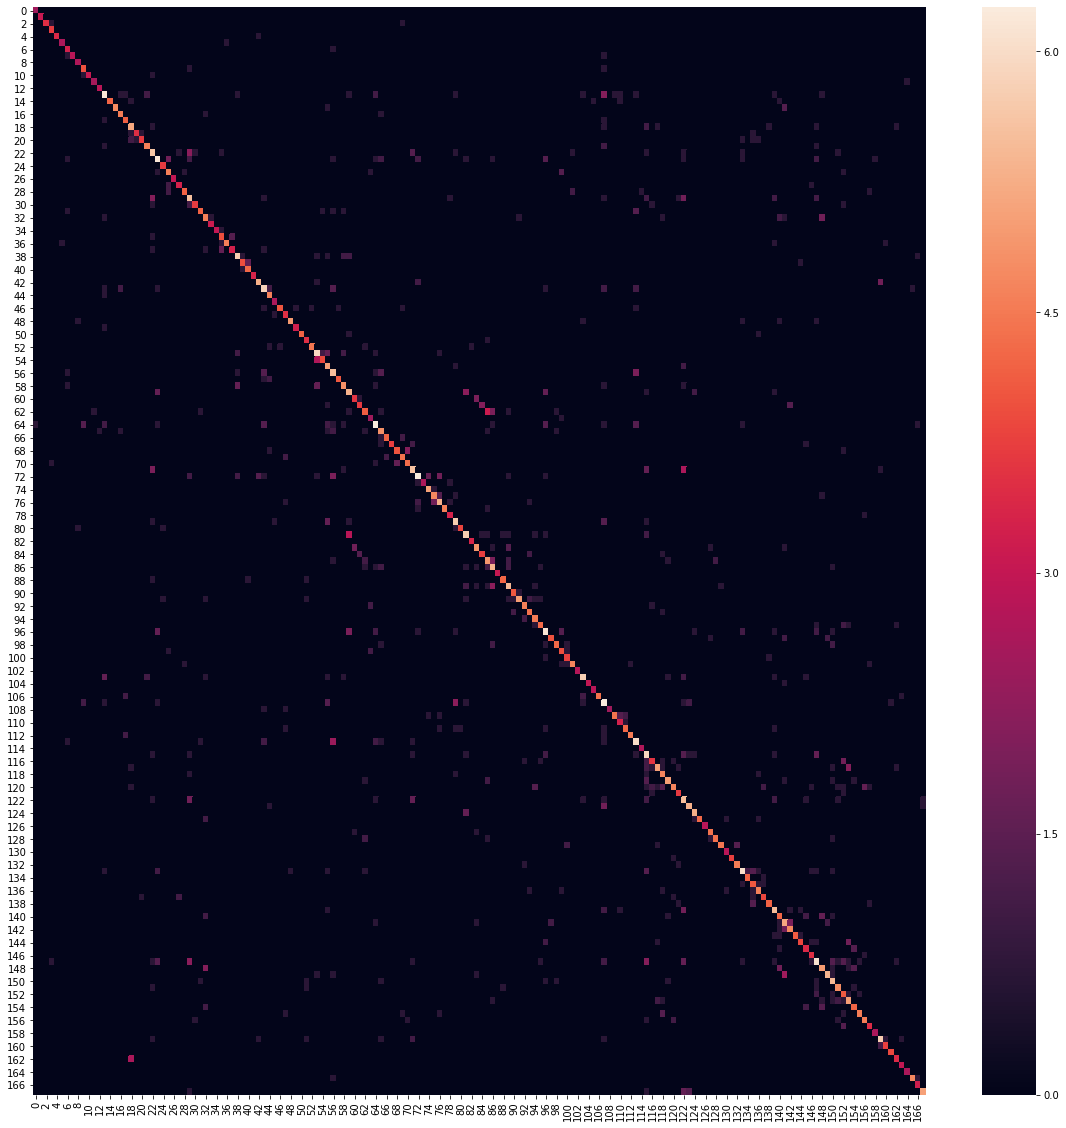

In [40]:
run_epochs(3)

In [0]:
plt.plot([sum(t) for t in tr_losses])

In [0]:
plt.plot([t[0] for t in tr_losses])

In [0]:
plt.plot([t[1] for t in tr_losses])

In [0]:
plt.plot([t[2] for t in tr_losses])

In [0]:
plt.plot([t[0] for t in va_losses])

In [0]:
plt.plot([t[1] for t in va_losses])

In [0]:
plt.plot([t[2] for t in va_losses])

In [0]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/bhgd_r50_ls_p.pth')